# Automatic identification and structuring of AI companies for product creation

### Author: Chaitali Suhas Bagwe (cbagwe@mail.uni-paderborn.de)

***
#### Install Necessary Libraries

Remove the comment char '#' for installing the libraries

In [41]:
#!pip install requests
#!pip install beautifulsoup4
#!pip install psycopg2-binary
#!pip install mysql-connector
#!pip install mlflow
#!pip install mlflow[pipelines]
#!pip install mlflow[extras]
#!pip install mlflow-skinny
#!pip install wordcloud
#!pip install pyLDAvis
#!pip install translators
#!pip install gensim==3.4.0
#!pip install smart_open==1.9.0

In [42]:
# # Install MLflow
# !pip install mlflow

# # Install MLflow with the experimental MLflow Pipelines component
# !pip install mlflow[pipelines]  # for pip
# !conda install -c conda-forge mlflow-pipelines  # for conda

# # Install MLflow with extra ML libraries and 3rd-party tools
# !pip install mlflow[extras]

# # Install a lightweight version of MLflow
# !pip install mlflow-skinny

***
#### Import Libraries

In [128]:
from bs4 import BeautifulSoup
from deep_translator import GoogleTranslator
from mlflow import log_metric, log_param, log_artifacts, start_run
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn import svm,metrics
from urllib.request import Request, urlopen
from wordcloud import WordCloud


import gensim
import gensim.corpora as corpora
import matplotlib.pyplot as plt
import mysql.connector
import numpy as np
import pandas as pd
import pickle
import psycopg2
import pyLDAvis
import pyLDAvis.gensim_models
import random
import re
import requests
import scrapy
import translators as ts
import yake

%matplotlib inline

***
#### Read the data from the Excel File
In this block we read the data from excel file to the pandas dataframe and change the column name of "Relevance of service/app and fit to the portfolio" to "Relevance" for better readability/extraction. Since we are only interested in product engineering companies we will mark the "1 - product engineering" as "1" and others as "0". This makes the classification problem into binary classification.

In [77]:
#Read the input Excel file
dataset = pd.read_excel('NewCompaniesList.xlsx', sheet_name='New_Companies')

#Change column names
dataset.rename(columns = {'Relevance of service/app and fit to the portfolio':'Relevance'}, inplace = True)
dataset.rename(columns = {'Product/Service-Title':'Title'}, inplace = True)
dataset.rename(columns = {'Product engineering (cycles)':'Cycles'}, inplace = True)


dataset = dataset[dataset.Relevance != "3- AI general"]

#Change Relevance values
dataset.Relevance.replace('1 - product engineering',1, inplace = True)
dataset.Relevance.replace('2 - production',0, inplace = True)
# dataset.Relevance.replace('3- AI general',0, inplace = True)
dataset.Relevance.replace('4 - cross sectional processes',0, inplace = True)
dataset.Relevance.replace('5 - not relevant',0, inplace = True)

c:\users\chaitali bagwe\appdata\local\programs\python\python38\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


***
### Text Preprocessing

#### 1) Setting up stop-words and stemmer
Stop Words : Removing commonly used english stop words like *and*, *the*, *a*, *an*, etc. We have also removed the words that are not useful for us in the context of websites. These include the words from header and footer of the websites, dropdown menu words of the websites, terms and conditions, etc.

Stemmer : Reducing the word to its word stem; *extraction* -> *extract*

In [45]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

stop_words = stopwords.words("english")
# Add custom stop words (frequently occuring but add no value)
stop_words += ['about', 'us', 'contact', 'how','login', 'hello','email','home','blog','terms','conditions',
               'jobs','openings','careers','privacy','policy','legal','imprint','demo','support','team',
              'conditions']

***
#### 2) Clean Text Function

This function cleans the text received by the variable "text". Cleaning includes removal of stopwords, white spaces, html tags, numbers, special characters and punctuations. This function also tokenizes the text sent to it and performs stemming on each word.

In [46]:
def clean_text(text):
    
    # remove white spaces, html tags, numbers, special characters, punctuations
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]

    # perform stemming on each word
    words_filtered = [
        #stemmer.stem(word) 
        #lemmatizer.lemmatize(word)
        word for word in words_tokens_lower if word not in stop_words
    ]

    text_clean = " ".join(words_filtered)
    return text_clean

***
#### 3) Initialize the keyword extractor from Yake library

In [78]:
max_ngram_size = 1
deduplication_threshold = 0.9
num_of_keywords = 130
window_size = 1

kw_extractor = yake.KeywordExtractor(n=max_ngram_size, dedupLim=deduplication_threshold, top=num_of_keywords, windowsSize=window_size)

***
### Miscellaneous Functions

#### 1) Read Content from URL of the company

BeautifulSoup library is used for the extraction of content from the given URL. Additionally, the footer attributes and the website's cookies attributes are removed in this function.

In [48]:
def read_url_content(page):
    # read the content
    soup = BeautifulSoup(page.content, "html.parser")
    
    # remove the website cookies content
    for div in soup.find_all('div', attrs={'data-nosnippet' : 'true'}):
        div.decompose()
        
    # remove footer
    for footer in soup.find_all('footer'):
        footer.decompose()
        
    # translate the content to English  
    translator = GoogleTranslator(source='auto', target='en')
    translated_text = translator.translate(soup.text[:4999])
        
    # return the cleaned content
    return clean_text(translated_text)

***
#### 2) Parse the required contents from the dataframe.
This function reads the data from the dataframe and passes the URL of each company to the read_url_content() function. A try and catch block is added for checking if the URL is accessible or not.

In [49]:
def get_cleaned_webdata(dataframe):
    # create an empty list of page data
    page_data = []
    
    for index, row in dataframe.iterrows():
        URL = row["Link"]
        try:
            # access the URL
            headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36',}
            page = requests.get(URL, headers = headers)
            # append the URL content to the list
            page_data.append(read_url_content(page))
        except(ConnectionError, Exception):
            # for websites not accessible append empty string to the list
            page_data.append("")
    return page_data

***
#### 3) Metrics Function
Calculates the metrics for the given actual and predicted datasets.

In [50]:
def print_statistics(actual, predicted):
    avg = 'weighted'
    print("Accuracy:",metrics.accuracy_score(actual, predicted))
    print("Precision:",metrics.precision_score(actual, predicted, average=avg))
    print("Recall:",metrics.recall_score(actual, predicted, average=avg))
    print("F1 score:",metrics.f1_score(actual, predicted, average=avg))

***
#### 4) Extract Keywords Function

In [51]:
def extract_keywords(string):
    keywords = kw_extractor.extract_keywords(string)
    keywords = [x for (x,_) in keywords]
    return " ".join(keywords)

***
#### 5) Extract Topics from websites

In [52]:
def extract_topics(long_string):
    num_topics = 300
    # Create Dictionary
    id2word = corpora.Dictionary([long_string.split()])
    # Create Corpus
    texts = [long_string.split()]
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    try:
        lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
        x=lda_model.show_topics(num_topics=1, num_words=300,formatted=False)
        topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

        #Below Code returns Only Words 
        for topic,words in topics_words:
            return " ".join(words)
    except Exception as e:
        print(e)
        return ""

***
#### Create Wordcloud

In [53]:
def create_wordcloud(long_string):
    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
    # Generate a word cloud
    wordcloud.generate(long_string)
    # Visualize the word cloud
    return wordcloud.to_image()

***
#### Get clean data for all the websites

In [79]:
dataset["WebData"] = get_cleaned_webdata(dataset)
dataset["WebData"]

0      solution zero vision next generation visual qu...
1      machine monitoring signals products products m...
2      machine monitoring signals products products m...
3      page found signals products products machine m...
4      hemistereo nx world powerful ai enabled stereo...
                             ...                        
469                                                     
470                                                     
471                                                     
472                                                     
473                                                     
Name: WebData, Length: 374, dtype: object

***
#### Database Connection

In [ ]:
#establishing the connection
conn = psycopg2.connect(
   database="postgres", user='postgres', password='Chaitali@28', host='127.0.0.1', port= '5432'
)

conn.autocommit = True

#Creating a cursor object using the cursor() method
cursor = conn.cursor()

#Executing an MYSQL function using the execute() method
cursor.execute("select version()")

# Fetch a single row using fetchone() method.
data = cursor.fetchone()
print("Connection established to: ",data)

***
#### Inserting the data into database

In [ ]:
for index in dataset.index:
    cols  = "COMPANY_NAME", "PRODUCT", "WEBDATA", "RELEVANCE", "CATEGORY"
    columns = ['Company','Title','WebData','Relevance','Cycles']
    vals  = [dataset.at[index,col] for col in columns]
    query = "INSERT INTO COMPANIES(COMPANY_NAME,PRODUCT,WEBDATA,RELEVANCE,CATEGORY) VALUES('%s','%s','%s',%s,'%s')" % (vals[0], vals[1], vals[2],vals[3],vals[4])
    try:
        cursor.execute(query)
    except Exception as e:
        print(e)

***
#### Closing the Database Connection

In [ ]:
#Close the connection
cursor.close()
conn.close()

***
#### Segregration of Test and Train data for our ML model
The sampling helps us in having random and not fixed input to the model. We have used 60 samples of product engineering companies and 60 samples of other companies as our training dataset. Thus the size of training data is 120. For test data we have used random 20 samples from each type of companies. Thus the size of testing data is 40.

In [80]:
# Segregrate the product engineering and other data from the dataset
# query_1 = "select * from companies where relevance = 1;"
# query_2 = "select * from companies where relevance = 0;"
# try:
#         cursor.execute(query_1)
#         prod_engg_data = cursor.fetchall()
#         cursor.execute(query_2)
#         other_data = cursor.fetchall()
# except Exception as e:
#         print(e)
prod_engg_data = dataset[dataset['Relevance'] == 1]
other_data = dataset[dataset['Relevance'] == 0]

# Generate train and test data by random sampling of product engineering and other data and then appending it together.
# train_data = random.sample(prod_engg_data,60) + random.sample(other_data,60)
# test_data = random.sample(prod_engg_data,20) + random.sample(other_data,20)

train_data = prod_engg_data.sample(70).append(other_data.sample(70))
test_data = prod_engg_data.sample(30).append(other_data.sample(30))

***
#### Perform keyword extraction on the cleaned webdata 

In [81]:
keywords = True
if keywords:
    train_data["Keywords"] = train_data["WebData"].apply(extract_keywords)
    test_data["Keywords"] = test_data["WebData"].apply(extract_keywords)

***
#### Perform topic modelling on the cleaned webdata

In [58]:
topic_modelling = False
if topic_modelling:
    train_data["Topics"] = train_data["WebData"].apply(extract_topics)
    test_data["Topics"] = test_data["WebData"].apply(extract_topics)

cannot compute LDA over an empty collection (no terms)
cannot compute LDA over an empty collection (no terms)
cannot compute LDA over an empty collection (no terms)
cannot compute LDA over an empty collection (no terms)
cannot compute LDA over an empty collection (no terms)
cannot compute LDA over an empty collection (no terms)
cannot compute LDA over an empty collection (no terms)


***
#### Feature extraction using TF-IDF
TF-IDF measures how relvant a word is when compared with the entire document.

In [82]:
vector = "tfidf"
if vector == "tfidf":
    vectorizor = TfidfVectorizer()
elif vector =="count":
    vectorizor = CountVectorizer()

In [83]:
if keywords:
    # Transform the train and test cleaned input keywords to tfidf vectors respectively
    train_input = vectorizor.fit_transform(train_data["Keywords"]).toarray().tolist()
    test_input = vectorizor.transform(test_data["Keywords"]).toarray().tolist()
elif topic_modelling:
    # Transform the train and test cleaned input Topics to tfidf vectors respectively
    train_input = vectorizor.fit_transform(train_data["Topics"]).toarray().tolist()
    test_input = vectorizor.transform(test_data["Topics"]).toarray().tolist()
else:
    # Transform the train and test cleaned input webdata to tfidf vectors respectively
    train_input = vectorizor.fit_transform(train_data["WebData"]).toarray().tolist()
    test_input = vectorizor.transform(test_data['WebData']).toarray().tolist()

In [84]:
# Convert the train and test output data to list.
train_output = train_data['Relevance'].tolist()
test_output = test_data['Relevance'].tolist()

***
#### SVM Classifier

In [85]:
#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(train_input, train_output)

#Predict the response for test dataset
y_pred = clf.predict(test_input)

In [86]:
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(clf, open(filename, 'wb'))
pickle.dump(vectorizor, open('vectorizer.sav', "wb"))

***
#### Print the statistics for SVM Classifier

In [87]:
print_statistics(test_output,y_pred)

Accuracy: 0.7166666666666667
Precision: 0.7291421856639249
Recall: 0.7166666666666667
F1 score: 0.7127569698676429


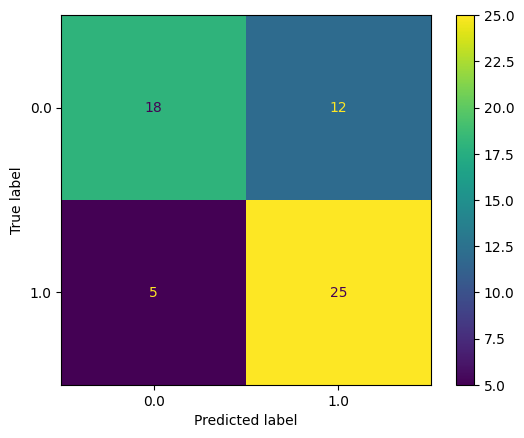

In [88]:
metrics.ConfusionMatrixDisplay.from_predictions(test_output,y_pred)
plt.show()

In [89]:
with start_run(run_name="svm_exp1") as run:
    avg = 'weighted'
    log_metric("Accuracy", metrics.accuracy_score(test_output, y_pred))  
    log_metric("Precision",metrics.precision_score(test_output, y_pred, average=avg))
    log_metric("Recall",metrics.recall_score(test_output, y_pred, average=avg))
    log_metric("F1 score",metrics.f1_score(test_output, y_pred, average=avg))
    log_param("keywords", keywords)
    log_param("topic_modelling", topic_modelling)

***
#### Naive Bayes Classifier

In [90]:
#Create a Gaussian Classifier
model = GaussianNB()

# Train the model using the training sets
model.fit(train_input,train_output)

#Predict Output
predicted= model.predict(test_input)

***
#### Print the statistics for Naive Bayes Classifier

In [91]:
print_statistics(test_output,predicted)

Accuracy: 0.65
Precision: 0.6586368977673326
Recall: 0.65
F1 score: 0.6451703745423826


In [92]:
with start_run(run_name="nb_exp1") as run:
    avg = 'weighted'
    log_metric("Accuracy", metrics.accuracy_score(test_output, predicted))  
    log_metric("Precision",metrics.precision_score(test_output, predicted, average=avg))
    log_metric("Recall",metrics.recall_score(test_output, predicted, average=avg))
    log_metric("F1 score",metrics.f1_score(test_output, predicted, average=avg))
    log_param("keywords", keywords)
    log_param("topic_modelling", topic_modelling)

***
#### Gradient Boosting Classification

In [93]:
clf = GradientBoostingClassifier()
clf.fit(train_input, train_output)  
pred = clf.predict(test_input)
print_statistics(test_output,y_pred)

Accuracy: 0.7166666666666667
Precision: 0.7291421856639249
Recall: 0.7166666666666667
F1 score: 0.7127569698676429


In [94]:
with start_run(run_name="gradbc_exp1") as run:
    avg = 'weighted'
    log_metric("Accuracy", metrics.accuracy_score(test_output, y_pred))  
    log_metric("Precision",metrics.precision_score(test_output, y_pred, average=avg))
    log_metric("Recall",metrics.recall_score(test_output, y_pred, average=avg))
    log_metric("F1 score",metrics.f1_score(test_output, y_pred, average=avg))
    log_param("keywords", keywords)
    log_param("topic_modelling", topic_modelling)

****
#### ADA Boost Classification

In [95]:
clf = AdaBoostClassifier()
clf.fit(train_input, train_output)  
pred = clf.predict(test_input)
print_statistics(test_output,y_pred)

Accuracy: 0.7166666666666667
Precision: 0.7291421856639249
Recall: 0.7166666666666667
F1 score: 0.7127569698676429


In [96]:
with start_run(run_name="ada_exp1") as run:
    avg = 'weighted'
    log_metric("Accuracy", metrics.accuracy_score(test_output, y_pred))  
    log_metric("Precision",metrics.precision_score(test_output, y_pred, average=avg))
    log_metric("Recall",metrics.recall_score(test_output, y_pred, average=avg))
    log_metric("F1 score",metrics.f1_score(test_output, y_pred, average=avg))
    log_param("keywords", keywords)
    log_param("topic_modelling", topic_modelling)

In [97]:
 # Join the different processed keywords together.
long_string = ','.join(list(train_data['Topics'].values))
create_wordcloud(long_string)

KeyError: 'Topics'

In [98]:
 # Join the different processed keywords together.
prodCrec_data = train_data[train_data['Relevance'] == 1]
prodCrec_string =  ','.join(list(prodCrec_data['Topics'].values))
create_wordcloud(prodCrec_string)

KeyError: 'Topics'

In [ ]:
 # Join the different processed keywords together.
non_prodCrec_data = train_data[train_data['Relevance'] == 0]
non_prodCrec_string =  ','.join(list(non_prodCrec_data['Topics'].values))
create_wordcloud(non_prodCrec_string)

In [99]:
target={'Strategic Product Planning':1, 'Product Development':2, 'production systems development':3}

cluster_train_data = prod_engg_data.head(70)
cluster_test_data = prod_engg_data.tail(30)

C:\Users\Chaitali Bagwe\AppData\Local\Temp\ipykernel_1320\3841182509.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_train_data['target']=cluster_train_data['Cycles'].map(target)
C:\Users\Chaitali Bagwe\AppData\Local\Temp\ipykernel_1320\3841182509.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_test_data['target']=cluster_test_data['Cycles'].map(target)


In [110]:
def lower_case(cycle):
    if isinstance(cycle, str):
        return cycle.lower()

In [126]:
def run_XGB_model(train_input, train_output, test_input):
    clf = HistGradientBoostingClassifier()
    clf.fit(train_input, train_output)  
    pred = clf.predict(test_input)
    return pred

In [118]:
def extract_possible_labels(data):
    possible_labels = data.unique()

    label_dict = {}
    for index, possible_label in enumerate(possible_labels):
        label_dict[possible_label] = index
    return label_dict

In [119]:
cluster_train_data['Cycles'] = cluster_train_data['Cycles'].apply(lower_case)
cluster_test_data['Cycles'] = cluster_test_data['Cycles'].apply(lower_case)

C:\Users\Chaitali Bagwe\AppData\Local\Temp\ipykernel_1320\1444177010.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_train_data['Cycles'] = cluster_train_data['Cycles'].apply(lower_case)
C:\Users\Chaitali Bagwe\AppData\Local\Temp\ipykernel_1320\1444177010.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_test_data['Cycles'] = cluster_test_data['Cycles'].apply(lower_case)


In [120]:
cluster_train_label_dict = extract_possible_labels(cluster_train_data.Cycles)
cluster_train_data['label'] = cluster_train_data.Cycles.replace(cluster_train_label_dict)

cluster_test_label_dict = extract_possible_labels(cluster_test_data.Cycles)
cluster_test_data['label'] = cluster_test_data.Cycles.replace(cluster_test_label_dict)

C:\Users\Chaitali Bagwe\AppData\Local\Temp\ipykernel_1320\161672684.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_train_data['label'] = cluster_train_data.Cycles.replace(cluster_train_label_dict)
C:\Users\Chaitali Bagwe\AppData\Local\Temp\ipykernel_1320\161672684.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_test_data['label'] = cluster_test_data.Cycles.replace(cluster_test_label_dict)


In [121]:
cluster_train_data["Keywords"] = cluster_train_data["WebData"].apply(extract_keywords)
cluster_test_data["Keywords"] = cluster_test_data["WebData"].apply(extract_keywords)

C:\Users\Chaitali Bagwe\AppData\Local\Temp\ipykernel_1320\1669283881.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_train_data["Keywords"] = cluster_train_data["WebData"].apply(extract_keywords)
C:\Users\Chaitali Bagwe\AppData\Local\Temp\ipykernel_1320\1669283881.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_test_data["Keywords"] = cluster_test_data["WebData"].apply(extract_keywords)


In [122]:
vectorizor = TfidfVectorizer()

In [130]:
# Transform the train and test cleaned input keywords to tfidf vectors respectively
train_input = vectorizor.fit_transform(cluster_train_data["Keywords"]).toarray().tolist()
test_input = vectorizor.transform(cluster_test_data["Keywords"]).toarray().tolist()

In [131]:
train_output = cluster_train_data['label'].tolist()
test_output = cluster_test_data['label'].tolist()

In [132]:
test_subclass_predictions = run_XGB_model(train_input, train_output, test_input)

In [133]:
print_statistics(test_output,test_subclass_predictions)

Accuracy: 0.8
Precision: 0.8133333333333332
Recall: 0.8
F1 score: 0.7882352941176471


c:\users\chaitali bagwe\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


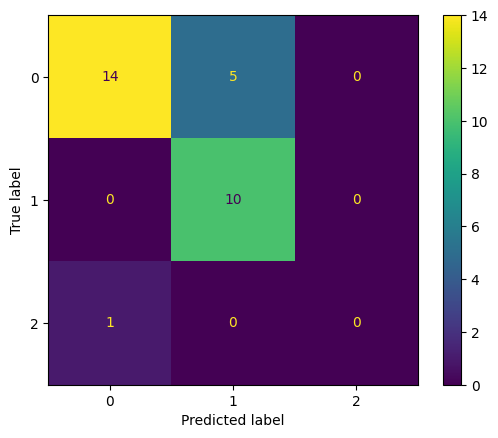

In [134]:
metrics.ConfusionMatrixDisplay.from_predictions(test_output,test_subclass_predictions)
plt.show()